In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append("./../..")

# standard lib
import shutil
from pathlib import Path

# external imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import scipy as sp
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import pickle
from torch.utils.data import DataLoader
import torch.nn as nn

# local imports
from effcn.functions import masking
from datasets.csprites import ClassificationDataset
from effcn.layers import Squash
from effcn.functions import margin_loss, max_norm_masking
from misc.utils import count_parameters
from misc.plot_utils import plot_couplings, plot_capsules, plot_mat, plot_mat2
from misc.metrics import *
from misc.utils import normalize_transform, inverse_normalize_transform

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

# Data

In [4]:
# black background
p_data = '/mnt/data/csprites/single_csprites_32x32_n7_c24_a12_p6_s2_bg_1_constant_color_145152'
p_data = '/home/matthias/projects/data/single_csprites_32x32_n7_c24_a12_p6_s2_bg_1_constant_color_145152'

# structured background
p_data = '/mnt/data/csprites/single_csprites_32x32_n7_c24_a12_p6_s2_bg_inf_random_function_145152'


p_ds_config = Path(p_data) / "config.pkl"
with open(p_ds_config, "rb") as file:
    ds_config = pickle.load(file)
target_variable = "shape"
target_idx = [idx for idx, target in enumerate(ds_config["classes"]) if target == target_variable][0]
n_classes = ds_config["n_classes"][target_variable]
#
norm_transform = normalize_transform(ds_config["means"],
                               ds_config["stds"])
#
target_transform = lambda x: x[target_idx]
transform = T.Compose(
    [T.ToTensor(),
     norm_transform,
    ])
inverse_norm_transform = inverse_normalize_transform(
    ds_config["means"],
    ds_config["stds"]
)

In [5]:
# TRAIN
batch_size = 512
num_workers = 4
#
ds_train = ClassificationDataset(
    p_data = p_data,
    transform=transform,
    target_transform=target_transform,
    split="train"
)
dl_train = DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False
)
# VALID
ds_valid = ClassificationDataset(
    p_data = p_data,
    transform=transform,
    target_transform=target_transform,
    split="valid"
)
dl_valid = DataLoader(
    ds_valid,
    batch_size=batch_size,
    shuffle=True,
    num_workers = num_workers,
    pin_memory=False
)
#
ds_concepts = ClassificationDataset(
    p_data = p_data,
    transform=transform,
    target_transform=None,
    split="valid"
)
dl_concepts = DataLoader(
    ds_concepts,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False   
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


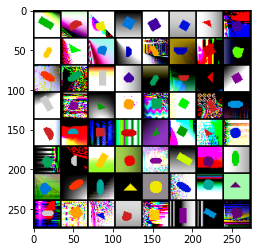

In [6]:
n_vis = 64
x,y = next(iter(dl_train))
x = x[:n_vis]
y = y[:n_vis]
#
x = inverse_norm_transform(x)
#
grid_img = torchvision.utils.make_grid(x, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))

# Models

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_classes, d_out):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(n_classes * d_out, 10*10)
        )
        
        self.layer2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding="valid"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding="valid"),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            #nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128, 3, kernel_size=(3, 3), padding="valid"),
            #nn.LeakyReLU(0.3,inplace=True),
            #nn.Conv2d(128, 3, kernel_size=(3, 3), padding="same"),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(-1, 1, 10, 10)
        x = self.layer2(x)
        return x


In [ ]:
model = Decoder(7, 16)
y = model(torch.rand(1, 7 * 16))
print(y.shape)
print(count_parameters(model))

### Backbone

In [ ]:
class CustomBB(nn.Module):
    """
        Custom backbone
    """
    def __init__(self, ch_in=3, n_classes=10):
        super().__init__()
        self.ch_in = ch_in
        self.n_classes=n_classes
    
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=ch_in, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=256, groups=32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=7, groups=32, stride=1, padding="valid"),
        )
        self.fc = nn.Linear(512 , n_classes)
    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)     # -> (b, 256), remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

class CustomBB(nn.Module):
    """
        Custom backbone
    """
    def __init__(self, ch_in=3, n_classes=10):
        super().__init__()
        self.ch_in = ch_in
        self.n_classes=n_classes
    
        self.convs = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, groups=1, stride=2, padding=0, bias=False),
            #nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, groups=32, stride=2, padding=0, bias=False),
            #nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=7, groups=32, stride=1, padding="valid", bias=False),
        )
        self.fc = nn.Linear(512 , n_classes)
    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)     # -> (b, 256), remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

class CustomBB(nn.Module):
    """
        Custom backbone
    """
    def __init__(self, ch_in=3, n_classes=10):
        super().__init__()
        self.ch_in = ch_in
        self.n_classes=n_classes
    
        self.convs = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, groups=1, stride=2, padding=0, bias=False),
            #nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(32, 256, 256kernel_size=3, groups=32, stride=2, padding=0, bias=False),
            #nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=7, groups=32, stride=1, padding="valid", bias=False),
        )
        self.fc = nn.Linear(512 , n_classes)
    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)     # -> (b, 256), remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

class CustomBB(nn.Module):
    """
        Custom backbone
    """
    def __init__(self, ch_in=3, n_classes=10):
        super().__init__()
        self.ch_in = ch_in
        self.n_classes=n_classes
    
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=ch_in, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=7, groups=32, stride=1, padding="valid"),
        )
        self.fc = nn.Linear(256 , n_classes)
    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)     # -> (b, 256), remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

class CustomBB(nn.Module):
    """
        Custom backbone
    """
    def __init__(self, ch_in=3, n_classes=10):
        super().__init__()
        self.ch_in = ch_in
        self.n_classes=n_classes
    
        self.convs = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, groups=1, stride=2, padding=0, bias=False),
            #nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(256, 256*8, kernel_size=3, groups=256, stride=2, padding=0, bias=False),
            #nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256*8, 256*8, kernel_size=7, groups=256, stride=1, padding="valid", bias=False),
        )
        self.fc = nn.Linear(256*8 , n_classes)
    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)     # -> (b, 256), remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

class CustomBB(nn.Module):
    """
        Custom backbone
    """
    def __init__(self, ch_in=3,
                 n_classes=10,
                 n_prime_caps=32,
                 d_prime_caps=8, filters=[128, 256]):
        super().__init__()
        self.ch_in = ch_in
        self.n_classes=n_classes
        self.n_prime_caps=n_prime_caps
        self.d_prime_caps=d_prime_caps
    
        self.convs = nn.Sequential(
            nn.Conv2d(3, filters[0], kernel_size=3, groups=1, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(num_features=filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[1], kernel_size=3, groups=1, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(num_features=filters[1]),
            nn.ReLU(),
            nn.Conv2d(filters[1], n_prime_caps * d_prime_caps, kernel_size=7, groups=n_prime_caps, stride=1, padding="valid", bias=False),
        )
        self.fc = nn.Linear(n_prime_caps * d_prime_caps , n_classes)
    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)     # -> (b, 256), remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

In [ ]:
class CustomBB(nn.Module):
    """
        Custom backbone
    """
    def __init__(self, ch_in=3,
                 n_classes=10,
                 n_prime_caps=32,
                 d_prime_caps=8, filters=[128, 256]):
        super().__init__()
        self.ch_in = ch_in
        self.n_classes=n_classes
        self.n_prime_caps=n_prime_caps
        self.d_prime_caps=d_prime_caps
    
        self.convs = nn.Sequential(
            nn.Conv2d(3, filters[0], kernel_size=3, groups=1, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(num_features=filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[1], kernel_size=3, groups=1, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(num_features=filters[1]),
            nn.ReLU(),
            nn.Conv2d(filters[1], n_prime_caps * d_prime_caps, kernel_size=7, groups=n_prime_caps, stride=1, padding="valid", bias=False),
        )
        self.fc = nn.Linear(n_prime_caps * d_prime_caps , n_classes)
    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)     # -> (b, 256), remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

In [ ]:
# Check if it works
model = CustomBB(ch_in=3, filters=[64, 128])
y = model(torch.rand(128, 3, 32, 32))
print(count_parameters(model))
print(y.shape)
model

In [ ]:
class FCCaps(nn.Module):
    """
        Attributes
        ----------
        n_l ... number of lower layer capsules
        d_l ... dimension of lower layer capsules
        n_h ... number of higher layer capsules
        d_h ... dimension of higher layer capsules

        W   (n_l, n_h, d_l, d_h) ... weight tensor
        B   (n_l, n_h)           ... bias tensor
    """

    def __init__(self, n_l, n_h, d_l, d_h, attention_scaling):
        super().__init__()
        self.n_l = n_l
        self.d_l = d_l
        self.n_h = n_h
        self.d_h = d_h
        
        
        self.W = torch.nn.Parameter(torch.rand(
            n_l, n_h, d_l, d_h), requires_grad=True)
        self.B = torch.nn.Parameter(torch.rand(n_l, n_h), requires_grad=True)
        self.squash = Squash(eps=1e-20)

        # init custom weights
        # i'm relly unsure about this initialization scheme
        # i don't think it makes sense in our case, but the paper says so ...
        torch.nn.init.kaiming_normal_(
            self.W, a=0, mode='fan_in', nonlinearity='leaky_relu')
        torch.nn.init.kaiming_normal_(
            self.B, a=0, mode="fan_in", nonlinearity="leaky_relu")

        self.attention_scaling = attention_scaling

    def forward(self, U_l):
        U_h, _ = self.forward_debug(U_l)
        return U_h

    def forward_debug(self, U_l):
        """
        einsum convenventions:
          n_l = i | h
          d_l = j
          n_h = k
          d_h = l

        Data tensors:
            IN:  U_l ... lower layer capsules
            OUT: U_h ... higher layer capsules
            DIMS:
                U_l (n_l, d_l)
                U_h (n_h, d_h)
                W   (n_l, n_h, d_l, d_h)
                B   (n_l, n_h)
                A   (n_l, n_l, n_h)
                C   (n_l, n_h)
        """
        """
            Same as forward() but returns more stuff to analyze routing
        """
        U_hat = torch.einsum('...ij,ikjl->...ikl', U_l, self.W)
        A = torch.einsum("...ikl, ...hkl -> ...hik", U_hat, U_hat)
        
        
        A_sum = torch.einsum("...hij->...hj", A)
        C = torch.softmax(A_sum / self.attention_scaling, dim=-1)
        
        # I removed the Bias term
        #CB = C + B
        
        U_h = torch.einsum('...ikl,...ik->...kl', U_hat, C)
        return self.squash(U_h), C
    
class DeepCapsNet(nn.Module):
    """
        A Deeper CN that allows
    """
    def __init__(self, ns, ds, attention_scaling, filters):
        super().__init__()
        self.ns = ns
        self.ds = ds
        
        self.backbone = CustomBB(
            ch_in=3,
            n_prime_caps=ns[0],
            d_prime_caps=ds[0],
            filters=filters
        )
        self.backbone.fc = nn.Identity()
        self.decoder = Decoder(ns[-1], ds[-1])
        
        self.squash = Squash(eps=1e-20)
        layers = []
        for idx in range(1, len(ns), 1):
            n_l = ns[idx - 1]
            n_h = ns[idx]
            d_l = ds[idx - 1]
            d_h = ds[idx]
            layers.append(FCCaps(n_l, n_h, d_l, d_h, attention_scaling) )
        self.layers = nn.Sequential(*layers)
        
        
        #self.PW = nn.Parameter(torch.rand(ns[0], ds[0], ds[0]))


    def forward(self, x, y_true=None):
        x = self.backbone(x)
        
        # primecaps
        x = x.view(-1, self.ns[0], self.ds[0])
        #x = torch.einsum("...nd,nkd->...nk", x, self.PW)
        x = self.squash(x)
        
        # fccaps
        for layer in self.layers:
            x = layer(x)
        
        # decoder
        u_h_masked = masking(x, y_true)
        x_rec = self.decoder(u_h_masked)
        return x, x_rec

    def forward_debug(self, x, y_true=None):
        x = self.backbone(x)
        
        # primecaps
        x = x.view(-1, self.ns[0], self.ds[0])
        #x = torch.einsum("...nd,nkd->...nk", x, self.PW)
        x = self.squash(x)
        
        us = [torch.clone(x)]
        cc = []
        # fccaps
        for layer in self.layers:
            x, c = layer.forward_debug(x)
            cc.append(c.detach())
            us.append(torch.clone(x).detach())
        
        u_h_masked = masking(x, y_true)
        x_rec = self.decoder(u_h_masked)
        
        return x, cc, us, x_rec

In [ ]:
attention_scaling = 0.1

ns = [32, 26, 20, 14, n_classes]
ds = [16, 16, 16, 16, 16]
#
ns = [32, 32, 32, n_classes]
ds = [8, 8, 8, 8]
#
ns = [64, 64, 64, n_classes]
ds = [8, 8, 8, 16]

ns = [256, 32, 32, n_classes]
ds = [8, 16, 16, 16]
filters = [64, 256]

model = DeepCapsNet(ns=ns, ds=ds, attention_scaling=attention_scaling, filters=filters)
#
print("tot Model ", count_parameters(model))
print("Backbone  ", count_parameters(model.backbone))
print("Decoder  ", count_parameters(model.decoder))
print("Routing  ", count_parameters(model.layers))
#
model = model.to(device)
#model

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.98)
#
func_rec_loss = torch.nn.MSELoss()

In [ ]:
n_vis = 16
x_vis, y_vis = next(iter(dl_valid))
x_vis = x_vis[:n_vis].to(device)
y_vis = y_vis[:n_vis].to(device)

In [ ]:
num_epochs = 11
do_overfit = False
if do_overfit:
    x_of, y_of = next(iter(dl_train))
    x_of = x_of[:10]
    y_of = y_of[:10]
    n_vis = 10
    x_vis = x_of.to(device)
    y_vis = y_of.to(device)
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        if do_overfit:
            x = x_of
            y_true = y_of
        x = x.to(device)
        y_true = y_true.to(device)
        #
        #
        optimizer.zero_grad()
        
        u_h, x_rec = model.forward(x, y_true)
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=n_classes)
        loss_mar = margin_loss(u_h, y_one_hot)
        
        loss_rec = func_rec_loss(inverse_norm_transform(x), x_rec) * 20
        
        loss = loss_rec + loss_mar

        loss.backward()
        
        optimizer.step()
        
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'rec': loss_rec.item(),
                 'mar': loss_mar.item(),
                 'acc': acc.item()
                 }
        )
    lr_scheduler.step()
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 1 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h, x_rec = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   csprites acc_valid: {:.3f}".format(total_correct / total))
    #
    with torch.no_grad():
        _, x_rec_vis = model(x_vis.to(device))
        _, x_rec_vis_mask = model(x_vis.to(device), y_vis.to(device))
    #
    grid_img = torch.cat([inverse_norm_transform(x_vis), x_rec_vis, x_rec_vis_mask], dim=0)
    grid_img = torchvision.utils.make_grid(grid_img, nrow=n_vis)
    plt.imshow(grid_img.permute(1, 2, 0).cpu())
    plt.show()

### results
epoch = 50 0.994 0.883, groups=256
epoch = 50 0.992 0.923, groups=32


# Visualize and Analyze

### Show parse tree and activations for individual samples

In [ ]:
x, y = next(iter(dl_valid))

model.eval()
with torch.no_grad():
    u_h, CC, US, x_rec = model.forward_debug(x.to(device))
y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
y_pred = y_pred.detach().cpu().numpy()
#
US = [u.cpu().numpy() for u in US]
CS = [c.cpu().numpy() for c in CC]
#
Y_true = y.cpu().numpy()
Y_pred = y_pred

In [ ]:
vis_class = None
vis_max = 4
for idx in range(vis_max):
    if vis_class is not None and Y_true[idx] != vis_class:
        continue
    cs = [c[idx] for c in CS]
    us = [u[idx] for u in US]
    u_norms = [np.linalg.norm(u, axis=1) for u in us]
    
    # plot stuff
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    title = "exp={} a={}".format(y[idx], y_pred[idx])
    #
    plot_couplings(cs, title=title, ax=axes[0], show=False)
    plot_capsules(u_norms, title=title , ax=axes[1], show=False)
    plt.show()

# Statistics For Further Evaluation and Visualization

In [ ]:
model.eval()

YY = []
CC = [[] for _ in range(len(ns) - 1)]
US = [[] for _ in range(len(ns))]


# use whole dataset
for x,y_true in dl_valid:
    x = x.to(device)
        
    with torch.no_grad():
        _, cc, us, _ = model.forward_debug(x.to(device))
        for idx in range(len(cc)):
            CC[idx].append(cc[idx].detach().cpu().numpy())
        for idx in range(len(us)):
            US[idx].append(us[idx].detach().cpu().numpy())
        YY.append(y_true.numpy())
        
# Dataset Labels
YY = np.concatenate(YY)

# Dataset Coupling Coefficient Matrices
CC = [np.concatenate(c) for c in CC]

# Dataset Capsules
US = [np.concatenate(u) for u in US]

### Mean parse tree and mean activation for dataset

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
# Mean parse tree
cc_mean = [np.mean(c, axis=0) for c in CC]
cc_std = [np.std(c, axis=0) for c in CC]
plot_couplings(cc_mean, ax=axes[0], show=False, title="mean couplings")
plot_couplings(cc_std, ax=axes[1], show=False, title="std couplings")
    
# mean and std capsule activation
us_mean = [np.linalg.norm(u, axis=-1).mean(axis=0) for u in US]
us_std = [np.linalg.norm(u, axis=-1).std(axis=0) for u in US]
us_max = [np.linalg.norm(u, axis=-1).max(axis=0) for u in US]
plot_capsules(us_mean, scale_factor=1, ax=axes[2], show=False, title="mean activation")
plot_capsules(us_std, scale_factor=1, ax=axes[3], show=False, title="std activation")
plot_capsules(us_max, scale_factor=1, ax=axes[4], show=False, title="max activation")
plt.suptitle("dataset")
plt.show()

### Parse tree from normalized Couplings

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10 * len(CC), 4))

CNS = [normalize_couplings(C) for C in CC]

CNS_MAN = [ma_couplings(C, pr) for C, pr in CNS]
CNS_MAX = [C.max(axis=0) for C, pr in CNS]
CNS_STD = [stda_couplings(C, pr) for C, pr in CNS]

plot_couplings(CNS_MAN, ax=axes[0], show=False, title="mean")
plot_couplings(CNS_STD, ax=axes[1], show=False, title="std")
plot_couplings(CNS_MAX, ax=axes[2], show=False, title="max")
plt.show()

### Classwise mean parse tree and mean activation

In [ ]:
# mean and variance activation
for cls in range(n_classes):
    idcs = np.where(YY == cls)[0]
    
    fig, axes = plt.subplots(1, 6, figsize=(24, 4))
    
    cc = [C[idcs] for C in CC]
    CNS = [normalize_couplings(C, eps_rate=0.5) for C in cc]
    
    CNS_MAN = [ma_couplings(C, pr) for C, pr in CNS]
    CNS_MAX = [C.max(axis=0) for C, pr in CNS]
    CNS_STD = [stda_couplings(C, pr) for C, pr in CNS]

    plot_couplings(CNS_MAN, ax=axes[0], show=False, title="mean")
    plot_couplings(CNS_STD, ax=axes[1], show=False, title="std")
    plot_couplings(CNS_MAX, ax=axes[2], show=False, title="max")
    
    # mean and std capsule activation
    us = [u[idcs] for u in US]
    us_mean = [np.linalg.norm(u, axis=-1).mean(axis=0) for u in us]
    us_std = [np.linalg.norm(u, axis=-1).std(axis=0) for u in us]
    us_max = [np.linalg.norm(u, axis=-1).max(axis=0) for u in us]
    
    plot_capsules(us_mean, scale_factor=1, ax=axes[3], show=False, title="mean activation")
    plot_capsules(us_std, scale_factor=1, ax=axes[4], show=False, title="std activation")
    plot_capsules(us_max, scale_factor=1, ax=axes[5], show=False, title="max activation")
    plt.suptitle("class {}".format(cls))
    plt.show()

# Single Capsule Activity

In [ ]:
for U in US:
    U_norm = np.linalg.norm(U, axis=-1)
    una = U_norm.mean(axis=1).mean()
    print(una)

In [ ]:
U_norm.mean(axis=1).shape

In [ ]:
U_norm.mean()

# Death vs Alive

In [ ]:
c_th_mu = 1e-2
c_th_sd = 1e-2

fig, axes = plt.subplots(len(US), 3, figsize=(6, 3 * len(US)))
#
US_alive = []
for idx in range(len(US)):
    U = US[idx]
    U_norm = np.linalg.norm(U, axis=2)
    U_norm_mu = U_norm.mean(axis=0)
    U_norm_sd = U_norm.std(axis=0)
    U_norm_max = U_norm.max(axis=0)
    #
    U_dead = (U_norm_sd < 1e-2) * (U_norm_mu < 1e-2)
    #
    xx = range(len(U_norm_mu))
    axes[idx][0].set_title("mu(norm(U))")
    axes[idx][0].bar(xx, U_dead, color="red",alpha=0.1)
    axes[idx][0].bar(xx, U_norm_mu)
    axes[idx][0].set_ylim(0, 1)
    axes[idx][1].set_title("sd(norm(U))")
    axes[idx][1].bar(xx, U_norm_sd)
    axes[idx][1].bar(xx, U_dead, color="red",alpha=0.1)
    axes[idx][1].set_ylim(0, 1)
    #
    axes[idx][2].set_title("max(norm(U))")
    axes[idx][2].bar(xx, U_norm_max)
    axes[idx][2].bar(xx, U_dead, color="red",alpha=0.1)
    axes[idx][2].set_ylim(0, 1)
    U_alive = 1 - U_dead
    US_alive.append(U_alive)
plt.show()

# Metrics

### Vibrance

In [ ]:
for U in US:
    pr = rate_dead_capsules_norm(U)
    print("#Permanently Dead: {:.3f}".format(pr.mean()))

In [ ]:
for C in CC:
    pr = rate_inactive_capsules(C)
    print("Rate inactive capsules {:.3f}".format(pr.mean()))

In [ ]:
# sanity check
for idx in range(len(CC)):
    C = CC[idx]
    U = US[idx]
    #
    rnd, rac, racnd =  get_vibrance(U, C)
    #
    print("rate alive: {:.3f} rate active {:.3f} rate active of alive {:.3f}".format(
        rnd, rac, racnd))

### Bonding

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    b = get_bonding(C)
    print_str = "bonding strength: {:.3f}"
    print(print_str.format(b))

### Dynamics

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    dyc = get_dynamics(C)
    #
    print("dynamics: {:.3f}".format(
          dyc))

### Correlation Capsule Activation and Max Coupling

In [ ]:
for idx in range(len(CC)):
    U = US[idx]
    C = CC[idx]
    print("corr: {:.3f}".format(activation_coupling_corr(C, U)))

### metrics for whole dataset

In [ ]:
vals = []
for idx in range(len(CC)):
    C = CC[idx]
    U = US[idx]
    #
    rnd, rac, racnd = get_vibrance(U, C)
    b = get_bonding(C)
    dyc = get_dynamics(C)
    cor = activation_coupling_corr(C, U)
    vals.append((idx,
                 rnd, rac, racnd,
                 b, dyc, cor))

In [ ]:
cols = ["layer",
        "alive rate", "active rate", "active of alive rate",
        "bonding str.", "dynamics", "cor"]
df = pd.DataFrame(data=vals, columns=cols)
df

### metrics for whole dataset, but classwise

In [ ]:

vals = []

#
for cls in range(10):
    idcs = np.where(YY == cls)[0]
    for idx in range(len(CC)):
        C = CC[idx][idcs]
        U = US[idx][idcs]
        #
        rnd, rac, racnd = get_vibrance(U, C)
        b = get_bonding(C)
        dyc = get_dynamics(C)
        cor = activation_coupling_corr(C, U)
        vals.append((cls, idx,
                     rnd, rac, racnd,
                     b, dyc, cor))

In [ ]:
cols = ["class", "layer",
        "alive rate", "active rate", "active of alive rate",
        "bonding str.", "dynamics", "cor"]
df = pd.DataFrame(data=vals, columns=cols)
#

In [ ]:
for idx in range(len(CC)):
    sdf = df[df["layer"] == idx].drop(columns=["layer"])
    print(sdf)

# Concepts

In [ ]:
def get_data(model, dl, device):
    model.eval()
    #
    YY = []
    CC = [[] for _ in range(len(ns) - 1)]
    US = [[] for _ in range(len(ns))]


    # use whole dataset
    for x,y_true in dl:
        x = x.to(device)

        with torch.no_grad():
            _, cc, us, _ = model.forward_debug(x.to(device))
            for idx in range(len(cc)):
                CC[idx].append(cc[idx].detach().cpu().numpy())
            for idx in range(len(us)):
                US[idx].append(us[idx].detach().cpu().numpy())
            YY.append(y_true.numpy())

    # Dataset Labels
    YY = np.concatenate(YY)

    # Dataset Coupling Coefficient Matrices
    CC = [np.concatenate(c) for c in CC]

    # Dataset Capsules
    US = [np.concatenate(u) for u in US]
    return YY, CC, US

In [ ]:
idcs = np.arange(YY.shape[0])
np.random.shuffle(idcs)
#
n_train = int(len(idcs) * 0.85)
n_valid = len(idcs) - n_train
#
idcs_train = idcs[:n_train]
idcs_valid = idcs[n_train:]
#
print(idcs_train.shape, idcs_valid.shape)

In [ ]:
YY, CC, US = get_data(model, dl_concepts, device)

In [ ]:
from sklearn.linear_model import LogisticRegression

# TSNE

In [ ]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

In [ ]:
layer_idx = 0
n_classes = len(ds_config["classes"])


U = US[layer_idx]
pr = rate_dead_capsules_norm(U)
U = U[:, (1 - pr) > 0, :]
#
R = []
#
print(U.shape)
for caps_idx in range(U.shape[1]):
    print(caps_idx)
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
    tsne_results = tsne.fit_transform(U[idcs_valid][:, caps_idx, :])
    R.append(tsne_results)

In [ ]:
import pickle
with open("tsne.pkl", "wb") as file:
    pickle.dump(R, file)

In [ ]:
with open("tsne.pkl", "rb") as file:
    R = pickle.load(file)

In [ ]:
scale_factor = 4

for caps_idx in range(U.shape[1]):
    tsne_results = R[caps_idx]
    fig, axes = plt.subplots(1, n_classes, figsize=(n_classes * scale_factor, 1 * scale_factor))
    for cls_idx in range(n_classes):
        ax = axes[cls_idx]
        y = YY[:,cls_idx][idcs_valid]
        res = ax.scatter(tsne_results[:,0], tsne_results[:,1], c=y)
        legend = [str(cls) for cls in range(n_classes)]
        #ax.legend(handles=res.legend_elements()[0], labels=legend, loc='upper left')
    plt.show()

In [ ]:
scale_factor = 4
fig, axes = plt.subplots(U.shape[1], n_classes, figsize=(n_classes * scale_factor, U.shape[1] * scale_factor))

for caps_idx in range(U.shape[1]):
    tsne_results = R[caps_idx]
    for cls_idx in range(n_classes):
        ax = axes[caps_idx][cls_idx]
        y = YY[:,cls_idx][idcs_valid]
        res = ax.scatter(tsne_results[:,0], tsne_results[:,1], c=y)
        legend = [str(cls) for cls in range(n_classes)]
        #ax.legend(handles=res.legend_elements()[0], labels=legend, loc='upper left')
plt.show()

### Via Instantiation Parameters

In [ ]:
ds_config["classes"]
#

#
S = []
for lay_idx in range(len(US)):
    U = US[lay_idx]
    for cls_idx in range(YY.shape[1]):
        Y = YY[:, cls_idx]
        for caps_idx in range(U.shape[1]):
            u = U[:, caps_idx, :]
            u_train = u[idcs_train]
            u_valid = u[idcs_valid]
            #
            y_train = Y[idcs_train]
            y_valid = Y[idcs_valid]
            #
            clf = LogisticRegression(random_state=0).fit(u_train, y_train)
            score = clf.score(u_valid, y_valid)
            S.append([lay_idx, cls_idx, caps_idx, score])
            print(lay_idx, cls_idx, caps_idx, score)

In [ ]:
cols = ["layer", "cls", "caps", "score"]
df = pd.DataFrame(data=S, columns=cols)

In [ ]:
layer_idx = 0

n_classes = len(ds_config["classes"])
fig, axes = plt.subplots(len(US),n_classes, figsize=(24, 4))

for layer_idx in range(len(US)):
    data = df[df["layer"] == layer_idx]
    data = data.drop(columns=["layer"])
    for cls_idx in range(n_classes):
        d = data[data["cls"] == cls_idx]
        ax = axes[layer_idx][cls_idx]
        #
        cls_name = ds_config["classes"][cls_idx]
        #
        ax.bar(d["caps"].values, d["score"].values)
        ax.set_ylim(0, 1)
        exp_rand = 1/ds_config["n_classes"][cls_name]
        ax.plot(d["caps"].values, np.ones(len(d["caps"].values)) * exp_rand, c="red")
        ax.set_title(cls_name)
    #
    #n_caps = US[lay_idx].shape[1]
    #
plt.tight_layout()

### Via Norms

In [ ]:
ds_config["classes"]
#

#
S = []
for lay_idx in range(len(US)):
    U = US[lay_idx]
    for cls_idx in range(YY.shape[1]):
        Y = YY[:, cls_idx]
        for caps_idx in range(U.shape[1]):
            u = U[:, caps_idx, :]
            u = np.linalg.norm(u, axis=-1).reshape(-1, 1)
            u_train = u[idcs_train]
            u_valid = u[idcs_valid]
            #
            y_train = Y[idcs_train]
            y_valid = Y[idcs_valid]
            #
            clf = LogisticRegression(random_state=0).fit(u_train, y_train)
            score = clf.score(u_valid, y_valid)
            S.append([lay_idx, cls_idx, caps_idx, score])
            print(lay_idx, cls_idx, caps_idx, score)

In [ ]:
cols = ["layer", "cls", "caps", "score"]
df = pd.DataFrame(data=S, columns=cols)

In [ ]:
layer_idx = 0

n_classes = len(ds_config["classes"])
fig, axes = plt.subplots(len(US),n_classes, figsize=(24, 4))

for layer_idx in range(len(US)):
    data = df[df["layer"] == layer_idx]
    data = data.drop(columns=["layer"])
    for cls_idx in range(n_classes):
        d = data[data["cls"] == cls_idx]
        ax = axes[layer_idx][cls_idx]
        #
        cls_name = ds_config["classes"][cls_idx]
        exp_rand = 1/ds_config["n_classes"][cls_name]
        #
        ax.bar(d["caps"].values, d["score"].values)
        ax.plot(d["caps"].values, np.ones(len(d["caps"].values)) * exp_rand, c="red")
        ax.set_ylim(0, 1)
        ax.set_title(cls_name)
    #
    #n_caps = US[lay_idx].shape[1]
    #
plt.tight_layout()

### Single Instances by norm

In [ ]:
import scipy as sp

In [ ]:
cls_idx = 4
cls_name = ds_config["classes"][cls_idx]
print(cls_name)
instances = ds_config["n_classes"][cls_name]
lay_idx = 0
#
U = US[lay_idx]
Y = YY[:, cls_idx]
#

for inst_idx in range(instances):
    S = []
    for caps_idx in range(U.shape[1]):
        u = U[:, caps_idx, :]
        u = np.linalg.norm(u, axis=-1)
        y = (Y == inst_idx) * 1
        #y = np.random.randint(0, 2, size=len(y))
        #
        #u_train = u[idcs_train]
        #u_valid = u[idcs_valid]
        #
        #y_train = y[idcs_train]
        #y_valid = y[idcs_valid]
        #
        #clf = LogisticRegression(random_state=0).fit(u_train, y_train)
        score = sp.stats.pearsonr(u, y)[0]
        S.append(score)
    #print(S)
    plt.bar(range(U.shape[1]), S)
    plt.ylim(-1, 1)
    plt.show()

In [ ]:
cls_idx = 2
cls_name = ds_config["classes"][cls_idx]
print(cls_name)
instances = ds_config["n_classes"][cls_name]
lay_idx = 0
#
U = US[lay_idx]
Y = YY[:, cls_idx]
#

for inst_idx in range(instances):
    S = []
    for caps_idx in range(U.shape[1]):
        u = U[:, caps_idx, :]
        u = np.linalg.norm(u, axis=-1).reshape(-1, 1)
        y = (Y == inst_idx) * 1
        y = np.random.randint(0, 2, size=len(y))
        #
        u_train = u[idcs_train]
        u_valid = u[idcs_valid]
        #
        y_train = y[idcs_train]
        y_valid = y[idcs_valid]
        #
        clf = LogisticRegression(random_state=0).fit(u_train, y_train)
        score = clf.score(u_valid, y_valid)
        #score = sp.stats.pearsonr(u, y)[0]
        S.append(score)
    #print(S)
    plt.bar(range(U.shape[1]), S)
    plt.ylim(-1, 1)
    plt.show()

# Couplings Viszalizations

#### Couplings FROM DEAD Capsules

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    C = C[:,np.where(Ul_alive == False)[0],:]
    
    if len(C.flatten()) < 1:
        print("No dead capsules for layer {}".format(idx))
        continue
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

#### Couplings FROM Alive Capsules

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    C = C[:,np.where(Ul_alive == True)[0],:]
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(42, 14))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

per sample count max coupling and use max to find out if coupling in general gets lower or just the average as they are loosly connected


### Couplings FROM ALIVE to DEAD

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    Uh_alive = US_alive[idx + 1]
    if (1 - Uh_alive).sum() < 1:
        print("{} No dead capsules for upper layer {}".format(idx ,idx + 1))
        continue
    
    
    C = C[:,np.where(Ul_alive == True)[0],:][:,:,np.where(Uh_alive == False)[0]]
    
    if len(C.flatten()) < 1:
        print("No dead capsules for layer {}".format(idx))
        continue
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

### Couplings FROM ALIVE TO ALIVE

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    Uh_alive = US_alive[idx + 1]
    if (Uh_alive).sum() < 1:
        print("No dead capsules for upper layer {}".format(idx + 1))
        continue
    
    
    C = C[:,np.where(Ul_alive == True)[0],:][:,:,np.where(Uh_alive == True)[0]]
    
    if len(C.flatten()) < 1:
        print("No dead capsules for layer {}".format(idx))
        continue
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

# CNN Only Baseline

In [ ]:
"""
epoch acc
010   96.0 85.5
020   99.6 87.0
050   1.00 88.4
100   1.09 88.6
"""

In [ ]:
model = CustomBB(ch_in=3, n_classes=n_classes)
#
model = model.to(device)
#backbone
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=2e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)
#
criterion = nn.CrossEntropyLoss()

In [ ]:
print(count_parameters(model))

In [ ]:
, acc = num_epochs = 51
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        logits = model.forward(x)
        loss = criterion(logits, y_true)

        loss.backward()
        
        optimizer.step()
        
        y_pred = torch.argmax(logits, dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item()
                 }
        )
    lr_scheduler.step()
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 5 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            logits = model.forward(x)
            
            y_pred = torch.argmax(logits, dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   mnist acc_valid: {:.3f}".format(total_correct / total))